In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy.random as npr
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

12


# Implementing the Node2Vec paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [171]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                # self.removed_nodes = []
                self.p = p
                self.q = q
                
                # Cutoffs for sampling
                self.p0 = 1. / self.p / max(1., self.p, self.q)
                self.p1 = 1. /  max(1., self.p, self.q)
                self.p2 = 1. / self.q / max(1., self.p, self.q)
                
                # Make the adjacency list using the graph
                self.adj_list = []
                for i in range(len(self.g)):
                        neighbors = np.where(self.g[i] > 0)[0]  # Get neighbor indices
                        weights = self.g[i, neighbors]  # Get corresponding edge weights

                        # Sort neighbors and weights by weight
                        sorted_neighbors_weights = sorted(zip(neighbors, weights), key=lambda x: x[0])

                        # print("Look at this : ", sorted_neighbors_weights)
                        
                        # Unpack sorted_neighbors_weights using a loop
                        sorted_neighbors = [neighbor for neighbor, _ in sorted_neighbors_weights]
                        sorted_weights = [weight for _, weight in sorted_neighbors_weights]

                        # if (len(sorted_neighbors) == 0) or (len(sorted_weights) == 0):
                        #         self.removed_nodes.append(i)

                        self.adj_list.append(list(zip(sorted_neighbors, sorted_weights / np.sum(sorted_weights))))
        
        def get_random_neighbour(self, vertex : 'int') -> 'int':
                """
                Fetches a random neighbour of a given vertex
                by sampling on the basis of the edge weights
                
                Parameters
                ----------
                vertex : int
                        The vertex whose neighbour we will sample
                        
                Returns
                -------
                int
                        The neighbour that was sampled
                """
                # Sample a neighbour with probability proportional
                # to the edge weight from vertex --> neighbour
                neighbours, weights = zip(*self.adj_list[vertex])
                
                # Sample a vertex with probability proportional 
                # to the weight of the edge joining it.
                return np.random.choice(neighbours, p=weights)
                    
        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node,
                        self.get_random_neighbour(start_node) # The prev_node is never Null
                ]

                # Generate the rest of the walk
                for i in range(2, walk_len):
                    # Variable to check whether we added to walk
                    found = False
                    new_node = None
                    
                    # Kep running until sampled in the red region
                    while not found:
                        new_node = self.get_random_neighbour(walk[-1])
                        r = np.random.rand()
                        
                        # Check if we will go back to the same node
                        if new_node == walk[-2]:
                            if r < self.p0:
                                found = True
                        
                        # Check if we are going to move by a distance of 1
                        elif self.g[walk[-2]][new_node]:
                            if r < self.p1:
                                found = True
                                    
                        else: # So we are moving by a distance of 2
                            if r < self.p2:
                                found = True
                                
                    walk.append(new_node)
            
                return walk

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []
                

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t starting from this "vertex"
                        for _ in range(self.gamma):
                                # if vertex not in self.removed_nodes:
                                # print(vertex)
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """          
                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n) ]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(6,6))
                plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)

                # Plot node numbers
                for i in range(len(embeddings)):
                        plt.annotate(i , (embeddings[i,0], embeddings[i,1]))
                        
                plt.show()

In [172]:
def plot_graph ( G , node_colours):
    plt.figure(figsize=(8,8))
    # scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]
    nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes,edgecolors="black", alpha=0.9)
    plt.axis("off")
    plt.show()

In [173]:
def ground_truth_loader(ground_truth_file):
    # Read data from the text file
    with open(ground_truth_file, 'r') as file:
        data = file.read()

    # Convert the data to a list of tuples representing node labels
    node_labels = [tuple(map(int, line.split())) for line in data.split('\n') if line.strip()]

    # Create a dictionary to store labels for each node
    labels_dict = {}
    for node, label in node_labels:
        labels_dict[node] = label

    # Assuming the nodes are consecutive starting from 0 to determine the number of nodes
    num_nodes = max(labels_dict.keys()) + 1

    # Generate the list of ground truth labels
    ground_truth_labels = [labels_dict[node] if node in labels_dict else None for node in range(num_nodes)]

    print("Ground Truth Labels:")
    print(ground_truth_labels)
    return ground_truth_labels

def connectivity_loader(file_name):
    # Read data from the text file
    with open(file_name, 'r') as file:
        data = file.read()

    # Convert the data to a list of tuples representing edges
    edges = [tuple(map(int, line.split())) for line in data.split('\n') if line.strip()]

    # Find the maximum node ID to determine the size of the adjacency matrix
    max_node = max(max(edge) for edge in edges) + 1

    # Initialize an empty adjacency matrix
    adj_matrix = np.zeros((max_node, max_node), dtype=int)

    # Fill the adjacency matrix based on the edges
    for edge in edges:
        u, v = edge
        adj_matrix[u][v] = 1  # For undirected graph, set both adjacencies
        adj_matrix[v][u] = 1

    print("Adjacency Matrix:")
    print(adj_matrix[:10, :10])
    return adj_matrix

In [174]:
# load the adjacency matrix
adjmat = connectivity_loader('connectivity.txt')

# Make the trace = 0
# np.fill_diagonal(adjmat, 0)

# load the ground truth data
gt_labels = ground_truth_loader('labels.txt')

# visualise the graph -> using networkx
G = nx.from_numpy_array(adjmat)

Adjacency Matrix:
[[1 1 0 0 0 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [1 0 1 0 0 1 1 1 0 0]
 [1 0 1 1 1 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 1 1]]
Ground Truth Labels:
[1, 1, 21, 21, 21, 25, 25, 14, 14, 14, 9, 14, 14, 26, 4, 17, 34, 1, 1, 14, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 5, 34, 14, 14, 17, 17, 10, 10, 36, 37, 5, 7, 4, 22, 22, 21, 21, 21, 21, 7, 7, 36, 21, 25, 4, 8, 15, 15, 15, 37, 37, 9, 1, 1, 10, 10, 3, 3, 3, 29, 15, 36, 36, 37, 1, 36, 34, 20, 20, 8, 15, 9, 4, 5, 4, 20, 16, 16, 16, 16, 16, 38, 7, 7, 34, 38, 36, 8, 27, 8, 8, 8, 10, 10, 13, 13, 6, 26, 10, 1, 36, 0, 13, 16, 16, 22, 6, 5, 4, 0, 28, 28, 4, 2, 13, 13, 21, 21, 17, 17, 14, 36, 8, 40, 35, 15, 23, 0, 0, 7, 10, 37, 27, 35, 35, 0, 0, 19, 19, 36, 14, 37, 24, 17, 13, 36, 4, 4, 13, 13, 10, 4, 38, 32, 32, 4, 1, 0, 0, 0, 7, 7, 4, 15, 16, 40, 15, 15, 15, 15, 0, 21, 21, 21, 21, 5, 4, 4

In [175]:
# # Find connected components
# components = list(nx.connected_components(G))

# # Select the largest connected component
# largest_component = max(components, key=len)
# largest_component_graph = G.subgraph(largest_component)

# # Visualize the largest connected component
# pos = nx.spring_layout(largest_component_graph)  # You can choose a different layout if needed

# # Set a larger figure size
# plt.figure(figsize=(12, 12))

# nx.draw(largest_component_graph, pos, with_labels=False, font_weight='bold', node_color='skyblue', node_size=20, edge_color='gray', linewidths=0.1)

# # Display the plot
# plt.show()

## Showing DeepWalk

In [183]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 1)

In [184]:
n2v.train(30, 0.05)

INFO - 2023-11-28 06:49:12,369: collecting all words and their counts
INFO - 2023-11-28 06:49:12,370: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-28 06:49:12,456: PROGRESS: at sentence #10000, processed 800000 words, keeping 1005 word types
INFO - 2023-11-28 06:49:12,458: collected 1005 word types from a corpus of 804000 raw words and 10050 sentences
INFO - 2023-11-28 06:49:12,459: Creating a fresh vocabulary
INFO - 2023-11-28 06:49:12,462: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 1005 unique words (100.00% of original 1005, drops 0)', 'datetime': '2023-11-28T06:49:12.462816', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-28 06:49:12,463: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 804000 word corpus (100.00% of original 804000, drops 0)', 'datetime': 

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


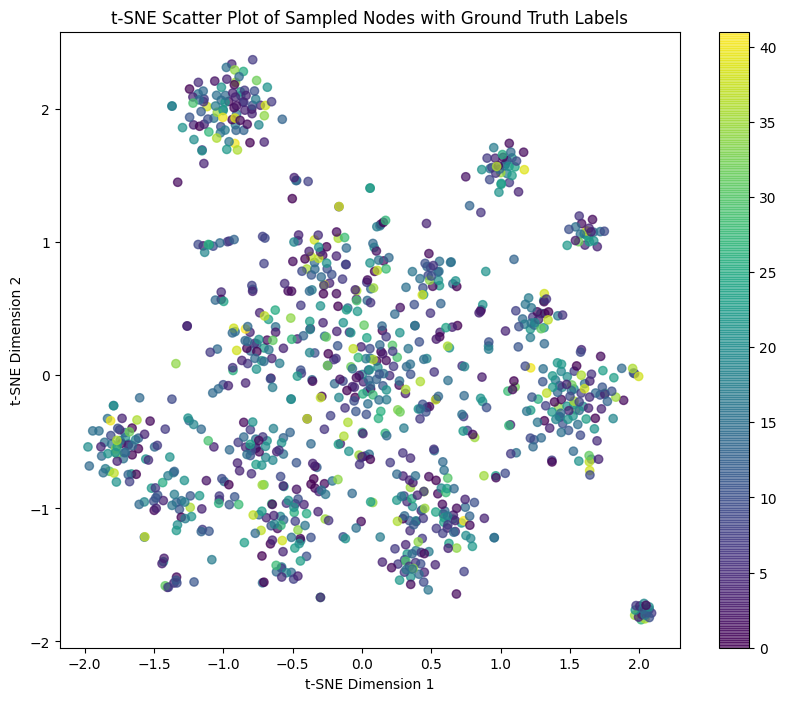

In [186]:
# # getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Import standard scaler
from sklearn.preprocessing import StandardScaler

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the embeddings for the sampled nodes
# embeddings = [model[node] for node in sampled_nodes]

# Get the ground truth labels for the sampled nodes
gt_labels_sampled = [gt_labels[node] for node in sampled_nodes]

# Convert the list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Scatter plot in 2D
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=gt_labels_sampled, cmap='viridis', alpha=0.7)
plt.title('t-SNE Scatter Plot of Sampled Nodes with Ground Truth Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


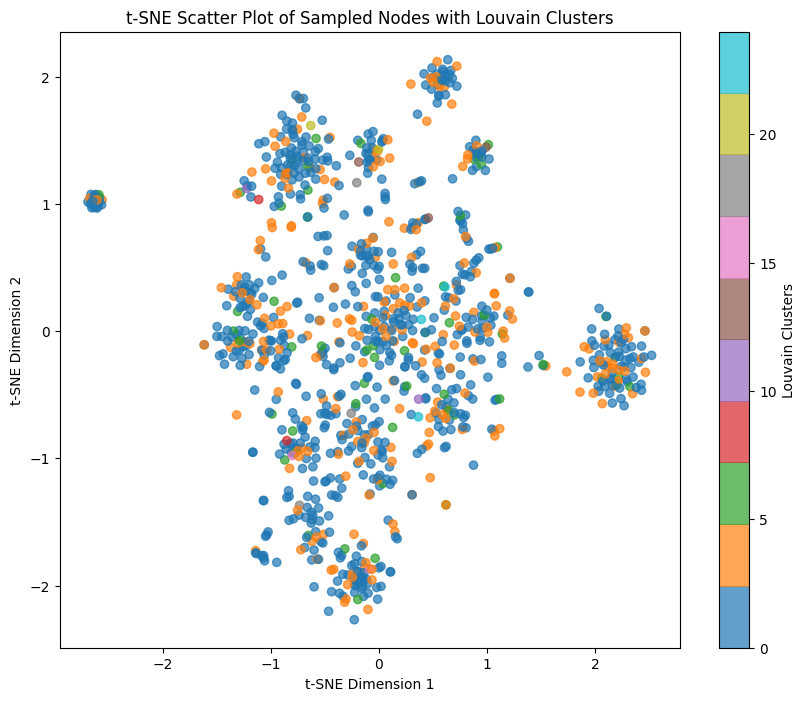

In [191]:
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sknetwork.clustering import Louvain, get_modularity

louvain = Louvain()

# Assuming you have 'G' (the graph), 'gt_labels', and 'n2v' (the node2vec model)

# Convert the graph to an adjacency matrix
adjmat = nx.adjacency_matrix(G).todense()

# Perform Louvain vertex modularity clustering
labels = louvain.fit_predict(adjmat)

# Getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())

# Sample some nodes from the graph
subgraph_size = 1005  # Adjust as needed
sampled_nodes = np.random.choice(list(G.nodes()), size=subgraph_size, replace=False)

# Get the embeddings for the sampled nodes
embeddings_array = np.array([embeddings[node] for node in sampled_nodes])

# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Standard scale
embeddings_2d = StandardScaler().fit_transform(embeddings_2d)

# Scatter plot in 2D with Louvain clusters as colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.title('t-SNE Scatter Plot of Sampled Nodes with Louvain Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Louvain Clusters')
plt.show()

In [180]:
# G = nx.karate_club_graph()
# nx.draw(G, with_labels=True, node_color=labels, cmap=plt.cm.rainbow)
# adjmat = nx.adjacency_matrix(G).todense()

In [181]:
# n2v.plot_embeddings(2, labels)

## Showing Homophily

In [182]:
''' do k means clustering for different p and q values and assign 
colours to the nodes based on the cluster they belong to '''

# p = 1, q=0.5
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 0.5)
n2v.train(30, 0.05)
embeddings = np.array(n2v.get_embeddings())

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_

plot_graph(G, labels)


INFO - 2023-11-28 06:48:11,846: collecting all words and their counts
INFO - 2023-11-28 06:48:11,846: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-28 06:48:11,921: PROGRESS: at sentence #10000, processed 800000 words, keeping 1005 word types
INFO - 2023-11-28 06:48:11,922: collected 1005 word types from a corpus of 804000 raw words and 10050 sentences
INFO - 2023-11-28 06:48:11,923: Creating a fresh vocabulary
INFO - 2023-11-28 06:48:11,926: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 1005 unique words (100.00% of original 1005, drops 0)', 'datetime': '2023-11-28T06:48:11.926559', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-28 06:48:11,927: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 804000 word corpus (100.00% of original 804000, drops 0)', 'datetime': 

KeyboardInterrupt: 

## Showing Structural Equivalence

INFO - 2023-11-28 06:21:43,277: collecting all words and their counts
INFO - 2023-11-28 06:21:43,278: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-28 06:21:43,279: collected 77 word types from a corpus of 2772 raw words and 924 sentences
INFO - 2023-11-28 06:21:43,279: Creating a fresh vocabulary
INFO - 2023-11-28 06:21:43,280: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 77 unique words (100.00% of original 77, drops 0)', 'datetime': '2023-11-28T06:21:43.280878', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-28 06:21:43,281: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 2772 word corpus (100.00% of original 2772, drops 0)', 'datetime': '2023-11-28T06:21:43.281497', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platfor

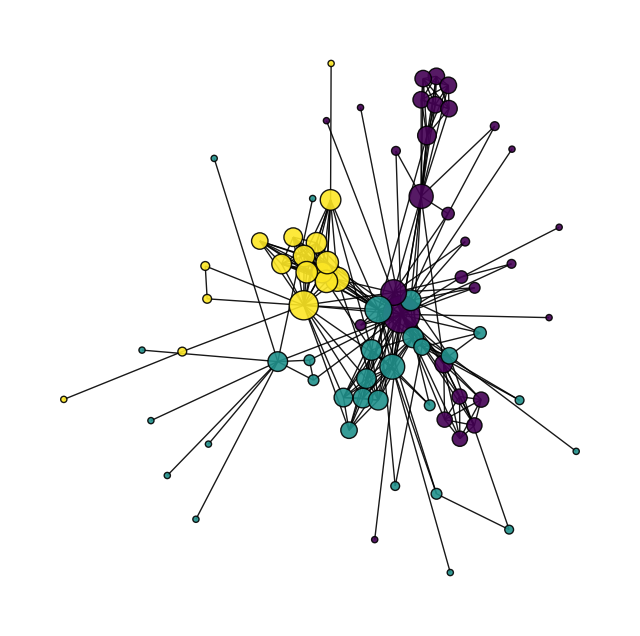

In [ ]:
# p = 1, q=2

# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
n2v_SE = Node2Vec(adjmat, 3, 16, 12, 3, 1, 2)
n2v_SE.train(30, 0.05)
embeddings = np.array(n2v_SE.get_embeddings())

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0,n_init=10).fit(embeddings)
labels = kmeans.labels_
plot_graph(G, labels)

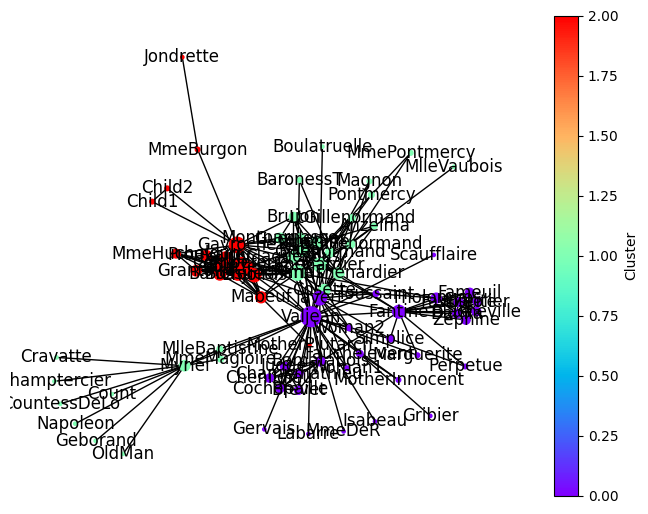

In [ ]:
# Compute node degrees
node_degrees = dict(G.degree())

# Determine the maximum degree for scaling node sizes
max_degree = max(node_degrees.values())

# Define a scaling factor for node sizes
scale_factor = 200  # Adjust this as needed to control the node size

# Compute node sizes proportional to their degree
node_sizes = [scale_factor * node_degrees[node] / max_degree for node in G.nodes]

# Plot the graph with nodes sized by their degree
pos = nx.spring_layout(G)  # Use a layout algorithm that suits your needs
nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.rainbow, node_size=node_sizes)

# Add colorbar for node colors
sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(labels), vmax=max(labels)))
sm.set_array([])
plt.colorbar(sm, label='Cluster')
plt.show()